# Import

In [1]:
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

ModuleNotFoundError: No module named 'jupyternotify'

In [2]:
import os
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import Trainer, TrainingArguments
from transformers import pipeline
from datasets import concatenate_datasets, load_dataset
from huggingface_hub import hf_hub_download
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datasets
from datasets import Dataset, Value, ClassLabel, Features
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
# os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
from transformers import DataCollatorWithPadding
import optuna
from huggingface_hub import notebook_login

# Datasets

In [3]:
# lables value

# 2 = positive
# 1 = neutral
# 0 = negative

In [4]:
dataset_tweet= load_dataset("cardiffnlp/tweet_sentiment_multilingual", "english")
dataset_tweet

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1839
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 324
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 870
    })
})

In [5]:
dataset_tweet_cc = concatenate_datasets([dataset_tweet['train'], dataset_tweet['validation'],dataset_tweet['test']])
dataset_tweet_cc

Dataset({
    features: ['text', 'label'],
    num_rows: 3033
})

In [6]:
dataset_mteb = load_dataset("mteb/tweet_sentiment_extraction")

In [7]:
dataset_mteb

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 27481
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 3534
    })
})

In [8]:
dataset_mteb_cc = concatenate_datasets([dataset_mteb['train'], dataset_mteb['test']])
dataset_mteb_cc

Dataset({
    features: ['id', 'text', 'label', 'label_text'],
    num_rows: 31015
})

In [9]:
dataset_mteb_cc=dataset_mteb_cc.remove_columns('label_text')
dataset_mteb_cc=dataset_mteb_cc.remove_columns('id')

dataset_mteb_cc

Dataset({
    features: ['text', 'label'],
    num_rows: 31015
})

In [10]:
dataset_tweet_cc.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

In [11]:
dataset_mteb_cc.features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [12]:
features = dataset_mteb_cc.features.copy()
features["label"] = ClassLabel(names=['negative', 'neutral', 'positive'])
def adjust_labels(batch):
    batch["label"] = [dataset_mteb_cc for dataset_mteb_cc in batch["label"]]
    return batch
label_dataset = dataset_mteb_cc.map(adjust_labels, batched=True, features=features)

In [13]:
label_dataset.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

In [14]:
dataset_cc = concatenate_datasets([label_dataset, dataset_tweet_cc])
dataset_cc

Dataset({
    features: ['text', 'label'],
    num_rows: 34048
})

## split 

In [15]:
ds = dataset_cc.train_test_split(test_size=0.2, stratify_by_column="label")
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 27238
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 6810
    })
})

In [16]:
train_dataset = ds['train']
validation_dataset = ds['test']
print(train_dataset)
print(validation_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 27238
})
Dataset({
    features: ['text', 'label'],
    num_rows: 6810
})


## test dataset

In [17]:
notebook_login()

In [18]:
raw_dataset=load_dataset("HFFErica/sentimentanalysis")
print(raw_dataset)

DatasetDict({
    test: Dataset({
        features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
        num_rows: 1700
    })
})


In [19]:
features = raw_dataset["test"].features.copy()
features["labels_three_2p"] = ClassLabel(names=['negative', 'neutral', 'positive'])
def adjust_labels(batch):
    batch["labels_three_2p"] = [test for test in batch["labels_three_2p"]]
    return batch
label_dataset = raw_dataset.map(adjust_labels, batched=True, features=features)

In [20]:
label_dataset["test"].features

{'sequence': Value(dtype='string', id=None),
 'labels': Value(dtype='string', id=None),
 'labels_five': Value(dtype='int64', id=None),
 'labels_three': Value(dtype='int64', id=None),
 'labels_three_2p': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

In [21]:
label_dataset_split = label_dataset['test'].train_test_split(test_size=0.4112, stratify_by_column="labels_three_2p")
label_dataset_split

DatasetDict({
    train: Dataset({
        features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
        num_rows: 700
    })
})

### test dataset groups

In [22]:
test_dataset=label_dataset_split['train']
test_dataset

Dataset({
    features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
    num_rows: 1000
})

In [23]:
pretrain_test_dataset=label_dataset_split['test']
pretrain_test_dataset

Dataset({
    features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
    num_rows: 700
})

In [24]:
test_dataset.features

{'sequence': Value(dtype='string', id=None),
 'labels': Value(dtype='string', id=None),
 'labels_five': Value(dtype='int64', id=None),
 'labels_three': Value(dtype='int64', id=None),
 'labels_three_2p': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

## label balance

<Axes: ylabel='count'>

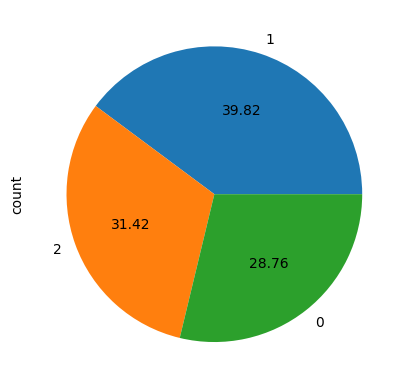

In [25]:
df_train = train_dataset.to_pandas()
df_train.label.value_counts().plot(kind = 'pie', autopct="%.2f")

<Axes: ylabel='count'>

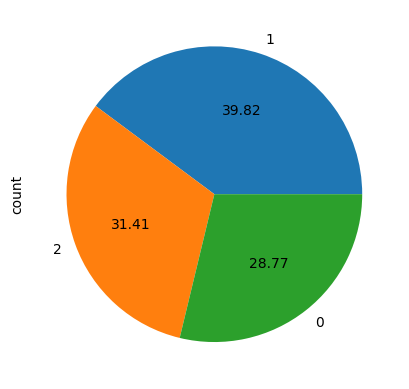

In [26]:
df_validation = validation_dataset.to_pandas()
df_validation.label.value_counts().plot(kind = 'pie', autopct="%.2f")

<Axes: ylabel='count'>

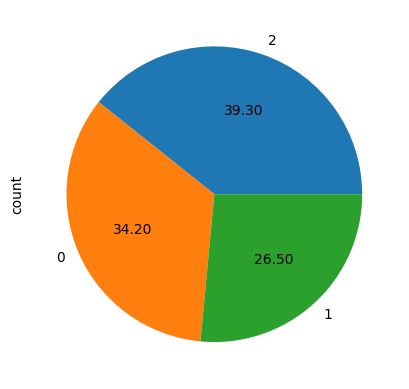

In [27]:
df_test = test_dataset.to_pandas()
df_test.labels_three_2p.value_counts().plot(kind = 'pie', autopct="%.2f")

<Axes: ylabel='count'>

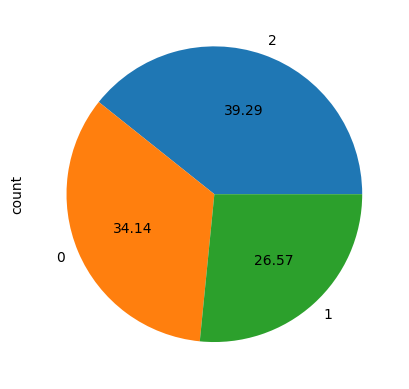

In [28]:
df_pretest = pretrain_test_dataset.to_pandas()
df_pretest.labels_three_2p.value_counts().plot(kind = 'pie', autopct="%.2f")

## Map

In [29]:
print(train_dataset)
print(validation_dataset)
print(test_dataset)
print(pretrain_test_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 27238
})
Dataset({
    features: ['text', 'label'],
    num_rows: 6810
})
Dataset({
    features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
    num_rows: 1000
})
Dataset({
    features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
    num_rows: 700
})


In [30]:
train_dataset = train_dataset.map(lambda examples: {'labels': examples['label']}, batched=True)
validation_dataset = validation_dataset.map(lambda examples: {'labels': examples['label']}, batched=True)
test_dataset = test_dataset.map(lambda examples: {'labels': examples['labels_three_2p']}, batched=True)

Map:   0%|          | 0/27238 [00:00<?, ? examples/s]

Map:   0%|          | 0/6810 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

# Model 

In [31]:
model_id="lxyuan/distilbert-base-multilingual-cased-sentiments-student"



label2id = {"positive": 2, "neutral": 1,"negative":0}

# 2 = positive
# 1 = neutral
# 0 = negative

model = AutoModelForSequenceClassification.from_pretrained(model_id, 
                                                           num_labels=train_dataset.features["label"].num_classes,id2label=label2id,
                                                          ignore_mismatched_sizes=True)
tokenizer = AutoTokenizer.from_pretrained(model_id)
model.config

DistilBertConfig {
  "_name_or_path": "lxyuan/distilbert-base-multilingual-cased-sentiments-student",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "negative": 0,
    "neutral": 1,
    "positive": 2
  },
  "initializer_range": 0.02,
  "label2id": {
    "negative": 2,
    "neutral": 1,
    "positive": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.34.0",
  "vocab_size": 119547
}

In [32]:
MAX_LENGTH = 256
train_dataset = train_dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)
validation_dataset = validation_dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)
test_dataset = test_dataset.map(lambda e: tokenizer(e['sequence'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)

Map:   0%|          | 0/27238 [00:00<?, ? examples/s]

Map:   0%|          | 0/6810 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [33]:
train_dataset.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None),
 'labels': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [34]:
# train_dataset.set_format(type='torch', columns=['input_ids','token_type_ids', 'attention_mask', 'labels'])
# validation_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
# test_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
validation_dataset.set_format(type='torch', columns=['input_ids',  'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [35]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# hyperparameter search

In [36]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_id, return_dict=True)

In [37]:
training_args = TrainingArguments("test",  eval_steps=500, disable_tqdm=True, do_eval=True, evaluation_strategy='steps')
trainer = Trainer(
    args=training_args,
    data_collator=DataCollatorWithPadding(tokenizer),
    train_dataset=train_dataset, 
    eval_dataset=validation_dataset, 
    model_init=model_init,
    compute_metrics=compute_metrics,
)

In [38]:
def my_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-3, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 1, 5),
#         "seed": trial.suggest_int("seed", 1, 40),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 24, 32, 36, 40, 48,56, 64,72]),
    }

In [39]:
trainer.hyperparameter_search(direction="maximize", hp_space=my_hp_space)

[I 2023-12-04 17:21:53,903] A new study created in memory with name: no-name-9a77487e-6a1e-4f54-af46-6cbf17120b7e
wandb: Currently logged in as: ericat. Use `wandb login --relogin` to force relogin


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 1.0945, 'learning_rate': 0.0003490366660418965, 'epoch': 0.88}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.0901049375534058, 'eval_accuracy': 0.39823788546255506, 'eval_f1': 0.1898760764545264, 'eval_precision': 0.1327459618208517, 'eval_recall': 0.3333333333333333, 'eval_runtime': 21.5329, 'eval_samples_per_second': 316.261, 'eval_steps_per_second': 39.567, 'epoch': 0.88}
{'loss': 1.0956, 'learning_rate': 7.463677135487094e-05, 'epoch': 1.76}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.0890047550201416, 'eval_accuracy': 0.39823788546255506, 'eval_f1': 0.1898760764545264, 'eval_precision': 0.1327459618208517, 'eval_recall': 0.3333333333333333, 'eval_runtime': 21.1174, 'eval_samples_per_second': 322.483, 'eval_steps_per_second': 40.346, 'epoch': 1.76}


[I 2023-12-04 17:31:23,540] Trial 0 finished with value: 1.0541932570712664 and parameters: {'learning_rate': 0.000623436560728922, 'num_train_epochs': 2, 'per_device_train_batch_size': 48}. Best is trial 0 with value: 1.0541932570712664.


{'train_runtime': 549.9263, 'train_samples_per_second': 99.061, 'train_steps_per_second': 2.066, 'train_loss': 1.0943508685474665, 'epoch': 2.0}


eval/accuracy,▁▁
eval/f1,▁▁
eval/loss,█▁
eval/precision,▁▁
eval/recall,▁▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁▆▆█
train/global_step,▁▁▇▇█
train/learning_rate,█▁


{'loss': 1.098, 'learning_rate': 1.066933709474332e-06, 'epoch': 1.03}
{'eval_loss': 0.892354428768158, 'eval_accuracy': 0.6201174743024963, 'eval_f1': 0.6218790274105608, 'eval_precision': 0.6255601348794784, 'eval_recall': 0.6205661574297999, 'eval_runtime': 21.3355, 'eval_samples_per_second': 319.187, 'eval_steps_per_second': 39.933, 'epoch': 1.03}
{'loss': 0.8389, 'learning_rate': 6.985173733298804e-07, 'epoch': 2.05}
{'eval_loss': 0.7693594694137573, 'eval_accuracy': 0.6657856093979442, 'eval_f1': 0.6686240890130658, 'eval_precision': 0.6681858434414852, 'eval_recall': 0.669238985942871, 'eval_runtime': 21.3224, 'eval_samples_per_second': 319.382, 'eval_steps_per_second': 39.958, 'epoch': 2.05}
{'loss': 0.7677, 'learning_rate': 3.3010103718542867e-07, 'epoch': 3.08}
{'eval_loss': 0.7365962266921997, 'eval_accuracy': 0.6807635829662262, 'eval_f1': 0.6838471677127651, 'eval_precision': 0.6835993671469361, 'eval_recall': 0.6841036181461043, 'eval_runtime': 21.336, 'eval_samples_per_s

[I 2023-12-04 17:48:23,482] Trial 1 finished with value: 2.7323137359720318 and parameters: {'learning_rate': 1.4353500456187836e-06, 'num_train_epochs': 4, 'per_device_train_batch_size': 56}. Best is trial 1 with value: 2.7323137359720318.


{'train_runtime': 1017.9845, 'train_samples_per_second': 107.027, 'train_steps_per_second': 1.914, 'train_loss': 0.8660082807286319, 'epoch': 4.0}


eval/accuracy,▁▆█
eval/f1,▁▆█
eval/loss,█▂▁
eval/precision,▁▆█
eval/recall,▁▆█
eval/runtime,█▁█
eval/samples_per_second,▁█▁
eval/steps_per_second,▁█▁
train/epoch,▁▁▃▃▆▆█
train/global_step,▁▁▃▃▆▆█
train/learning_rate,█▅▁


{'loss': 1.0744, 'learning_rate': 7.18266991557317e-07, 'epoch': 1.17}
{'eval_loss': 0.8873387575149536, 'eval_accuracy': 0.616446402349486, 'eval_f1': 0.6171055078041937, 'eval_precision': 0.6248500454628115, 'eval_recall': 0.6127747052483797, 'eval_runtime': 21.2557, 'eval_samples_per_second': 320.384, 'eval_steps_per_second': 40.083, 'epoch': 1.17}


[I 2023-12-04 17:57:44,162] Trial 2 finished with value: 2.471176660864871 and parameters: {'learning_rate': 1.7385326045648694e-06, 'num_train_epochs': 2, 'per_device_train_batch_size': 64}. Best is trial 1 with value: 2.7323137359720318.


{'train_runtime': 558.6882, 'train_samples_per_second': 97.507, 'train_steps_per_second': 1.525, 'train_loss': 0.991953388626027, 'epoch': 2.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁█
train/global_step,▁▁█
train/learning_rate,▁


{'train_runtime': 227.6162, 'train_samples_per_second': 119.666, 'train_steps_per_second': 2.14, 'train_loss': 1.1800336583194302, 'epoch': 1.0}


[I 2023-12-04 18:01:55,104] Trial 3 finished with value: 1.6115893330413333 and parameters: {'learning_rate': 1.1666712305285073e-06, 'num_train_epochs': 1, 'per_device_train_batch_size': 56}. Best is trial 1 with value: 2.7323137359720318.


{'eval_loss': 1.0540359020233154, 'eval_accuracy': 0.44552129221732745, 'eval_f1': 0.35315614495608244, 'eval_precision': 0.4148169361109509, 'eval_recall': 0.3980949597569725, 'eval_runtime': 21.2208, 'eval_samples_per_second': 320.912, 'eval_steps_per_second': 40.149, 'epoch': 1.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'loss': 0.7933, 'learning_rate': 5.738550509305169e-06, 'epoch': 1.17}
{'eval_loss': 0.6534073352813721, 'eval_accuracy': 0.7177679882525697, 'eval_f1': 0.7207104111067123, 'eval_precision': 0.7185282622418221, 'eval_recall': 0.7236981241804173, 'eval_runtime': 21.3078, 'eval_samples_per_second': 319.601, 'eval_steps_per_second': 39.985, 'epoch': 1.17}
{'loss': 0.6199, 'learning_rate': 2.0505360431707416e-06, 'epoch': 2.35}
{'eval_loss': 0.628547191619873, 'eval_accuracy': 0.7348017621145374, 'eval_f1': 0.7383912873326458, 'eval_precision': 0.7390845118415993, 'eval_recall': 0.737748237151688, 'eval_runtime': 21.2075, 'eval_samples_per_second': 321.113, 'eval_steps_per_second': 40.174, 'epoch': 2.35}


[I 2023-12-04 18:15:49,210] Trial 4 finished with value: 2.9500257984404703 and parameters: {'learning_rate': 9.426564975439597e-06, 'num_train_epochs': 3, 'per_device_train_batch_size': 64}. Best is trial 4 with value: 2.9500257984404703.


{'train_runtime': 832.1637, 'train_samples_per_second': 98.195, 'train_steps_per_second': 1.536, 'train_loss': 0.6811605462445899, 'epoch': 3.0}


eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,▁█
eval/recall,▁█
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁▆▆█
train/global_step,▁▁▅▅█
train/learning_rate,█▁


{'loss': 1.0986, 'learning_rate': 0.00027093107022323535, 'epoch': 0.73}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-12-04 18:19:10,519] Trial 5 pruned. 


{'eval_loss': 1.0891389846801758, 'eval_accuracy': 0.39823788546255506, 'eval_f1': 0.1898760764545264, 'eval_precision': 0.1327459618208517, 'eval_recall': 0.3333333333333333, 'eval_runtime': 21.1191, 'eval_samples_per_second': 322.457, 'eval_steps_per_second': 40.343, 'epoch': 0.73}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


{'loss': 1.094, 'learning_rate': 0.00022453990854616202, 'epoch': 0.88}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-12-04 18:22:57,917] Trial 6 pruned. 


{'eval_loss': 1.0911535024642944, 'eval_accuracy': 0.39823788546255506, 'eval_f1': 0.1898760764545264, 'eval_precision': 0.1327459618208517, 'eval_recall': 0.3333333333333333, 'eval_runtime': 21.122, 'eval_samples_per_second': 322.413, 'eval_steps_per_second': 40.337, 'epoch': 0.88}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


{'loss': 1.0943, 'learning_rate': 0.0005387906076774552, 'epoch': 0.59}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-12-04 18:25:45,079] Trial 7 pruned. 


{'eval_loss': 1.0904641151428223, 'eval_accuracy': 0.39823788546255506, 'eval_f1': 0.1898760764545264, 'eval_precision': 0.1327459618208517, 'eval_recall': 0.3333333333333333, 'eval_runtime': 21.089, 'eval_samples_per_second': 322.918, 'eval_steps_per_second': 40.4, 'epoch': 0.59}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


{'loss': 1.0926, 'learning_rate': 0.0002683619992324672, 'epoch': 1.32}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-12-04 18:35:54,270] Trial 8 pruned. 


{'eval_loss': 1.0892422199249268, 'eval_accuracy': 0.39823788546255506, 'eval_f1': 0.1898760764545264, 'eval_precision': 0.1327459618208517, 'eval_recall': 0.3333333333333333, 'eval_runtime': 20.8711, 'eval_samples_per_second': 326.288, 'eval_steps_per_second': 40.822, 'epoch': 1.32}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


{'loss': 1.1006, 'learning_rate': 0.00014141172030784343, 'epoch': 0.66}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-12-04 18:38:56,178] Trial 9 pruned. 


{'eval_loss': 1.0950684547424316, 'eval_accuracy': 0.39823788546255506, 'eval_f1': 0.1898760764545264, 'eval_precision': 0.1327459618208517, 'eval_recall': 0.3333333333333333, 'eval_runtime': 21.128, 'eval_samples_per_second': 322.321, 'eval_steps_per_second': 40.326, 'epoch': 0.66}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


{'loss': 0.7497, 'learning_rate': 1.1008519474507396e-05, 'epoch': 1.17}
{'eval_loss': 0.6357653737068176, 'eval_accuracy': 0.7305433186490455, 'eval_f1': 0.7334706420615053, 'eval_precision': 0.7321740176350303, 'eval_recall': 0.7356367671903975, 'eval_runtime': 21.2013, 'eval_samples_per_second': 321.207, 'eval_steps_per_second': 40.186, 'epoch': 1.17}
{'loss': 0.5746, 'learning_rate': 7.631673009934575e-06, 'epoch': 2.35}
{'eval_loss': 0.6118015050888062, 'eval_accuracy': 0.7425844346549192, 'eval_f1': 0.7466505839376308, 'eval_precision': 0.746973171278264, 'eval_recall': 0.7464156718773153, 'eval_runtime': 21.2084, 'eval_samples_per_second': 321.099, 'eval_steps_per_second': 40.173, 'epoch': 2.35}
{'loss': 0.5004, 'learning_rate': 4.254826545361754e-06, 'epoch': 3.52}
{'eval_loss': 0.6341868042945862, 'eval_accuracy': 0.7440528634361233, 'eval_f1': 0.7482232572210065, 'eval_precision': 0.7475783903065999, 'eval_recall': 0.7498280465998922, 'eval_runtime': 21.2084, 'eval_samples_pe

[I 2023-12-04 19:06:40,052] Trial 10 finished with value: 2.9864717819658537 and parameters: {'learning_rate': 1.4385365939080216e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 64}. Best is trial 10 with value: 2.9864717819658537.


{'train_runtime': 1662.4769, 'train_samples_per_second': 81.92, 'train_steps_per_second': 1.281, 'train_loss': 0.5635298518507693, 'epoch': 5.0}


eval/accuracy,▁▇██
eval/f1,▁▇██
eval/loss,▇▁▇█
eval/precision,▁███
eval/recall,▁▆█▇
eval/runtime,▄██▁
eval/samples_per_second,▅▁▁█
eval/steps_per_second,▅▁▁█
train/epoch,▁▁▃▃▅▅▇▇█
train/global_step,▁▁▃▃▅▅▇▇█
train/learning_rate,█▆▃▁


{'loss': 0.7715, 'learning_rate': 8.658444148803264e-06, 'epoch': 1.17}
{'eval_loss': 0.6438410878181458, 'eval_accuracy': 0.7242290748898679, 'eval_f1': 0.7271479676740226, 'eval_precision': 0.7256173734622572, 'eval_recall': 0.7296215100926715, 'eval_runtime': 21.2019, 'eval_samples_per_second': 321.198, 'eval_steps_per_second': 40.185, 'epoch': 1.17}
{'loss': 0.5946, 'learning_rate': 6.002479685980176e-06, 'epoch': 2.35}
{'eval_loss': 0.6137596368789673, 'eval_accuracy': 0.738913362701909, 'eval_f1': 0.7429890366100206, 'eval_precision': 0.7431811818083206, 'eval_recall': 0.743027972236003, 'eval_runtime': 21.0712, 'eval_samples_per_second': 323.191, 'eval_steps_per_second': 40.434, 'epoch': 2.35}
{'loss': 0.5298, 'learning_rate': 3.3465152231570894e-06, 'epoch': 3.52}
{'eval_loss': 0.6260280609130859, 'eval_accuracy': 0.7437591776798825, 'eval_f1': 0.7477540203586087, 'eval_precision': 0.7467439805566839, 'eval_recall': 0.749552133151615, 'eval_runtime': 21.0736, 'eval_samples_per_

[I 2023-12-04 19:53:02,793] Trial 11 finished with value: 2.9846950912996983 and parameters: {'learning_rate': 1.131440861162635e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 64}. Best is trial 10 with value: 2.9864717819658537.


{'train_runtime': 2780.7201, 'train_samples_per_second': 48.977, 'train_steps_per_second': 0.766, 'train_loss': 0.5916853013732624, 'epoch': 5.0}


eval/accuracy,▁▆██
eval/f1,▁▆██
eval/loss,█▁▄▄
eval/precision,▁▇██
eval/recall,▁▆██
eval/runtime,█▁▁▃
eval/samples_per_second,▁██▆
eval/steps_per_second,▁██▆
train/epoch,▁▁▃▃▅▅▇▇█
train/global_step,▁▁▃▃▅▅▇▇█
train/learning_rate,█▆▃▁


{'loss': 0.7803, 'learning_rate': 2.044364824569593e-05, 'epoch': 0.44}
{'eval_loss': 0.6438535451889038, 'eval_accuracy': 0.7258443465491924, 'eval_f1': 0.7288859656134608, 'eval_precision': 0.7327872289144293, 'eval_recall': 0.7260230561657353, 'eval_runtime': 21.2233, 'eval_samples_per_second': 320.874, 'eval_steps_per_second': 40.145, 'epoch': 0.44}
{'loss': 0.6522, 'learning_rate': 1.8468416531135938e-05, 'epoch': 0.88}
{'eval_loss': 0.620505154132843, 'eval_accuracy': 0.745374449339207, 'eval_f1': 0.7493733796464693, 'eval_precision': 0.7518507428244711, 'eval_recall': 0.7497475435862885, 'eval_runtime': 21.1945, 'eval_samples_per_second': 321.31, 'eval_steps_per_second': 40.199, 'epoch': 0.88}
{'loss': 0.552, 'learning_rate': 1.6493184816575946e-05, 'epoch': 1.32}
{'eval_loss': 0.617943286895752, 'eval_accuracy': 0.7422907488986784, 'eval_f1': 0.7450479637513414, 'eval_precision': 0.7543436801936644, 'eval_recall': 0.7396944693370529, 'eval_runtime': 21.1726, 'eval_samples_per_s

[I 2023-12-04 20:21:53,687] Trial 12 finished with value: 2.9863041853734207 and parameters: {'learning_rate': 2.2418879960255925e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 24}. Best is trial 10 with value: 2.9864717819658537.


{'train_runtime': 1728.8318, 'train_samples_per_second': 78.776, 'train_steps_per_second': 3.283, 'train_loss': 0.4381311129263319, 'epoch': 5.0}


eval/accuracy,▁▇▆█▇█▇▆█▇▆
eval/f1,▁▇▆█▇█▇▇▇▇▆
eval/loss,▂▁▁▁▃▂▄▅▆██
eval/precision,▁▇▇█▇▆▆▆▇▆▅
eval/recall,▁▇▄█▇██▆▇▇▆
eval/runtime,▆▃▁▄▆▅▂▇█▅█
eval/samples_per_second,▃▆█▅▃▄▇▂▁▄▁
eval/steps_per_second,▃▆█▅▃▄▇▂▁▄▁
train/epoch,▁▁▂▂▂▂▃▃▄▄▄▄▅▅▆▆▆▆▇▇███
train/global_step,▁▁▂▂▂▂▃▃▄▄▄▄▅▅▆▆▆▆▇▇███
train/learning_rate,█▇▇▆▅▅▄▃▂▂▁


{'loss': 0.763, 'learning_rate': 3.59596338505392e-05, 'epoch': 0.44}
{'eval_loss': 0.640515923500061, 'eval_accuracy': 0.7358296622613804, 'eval_f1': 0.7374629632733619, 'eval_precision': 0.7465859165228198, 'eval_recall': 0.7328719099472553, 'eval_runtime': 21.3007, 'eval_samples_per_second': 319.707, 'eval_steps_per_second': 39.999, 'epoch': 0.44}
{'loss': 0.6475, 'learning_rate': 3.2485273092033e-05, 'epoch': 0.88}
{'eval_loss': 0.6161613464355469, 'eval_accuracy': 0.7409691629955947, 'eval_f1': 0.7448636594368524, 'eval_precision': 0.7456488892619205, 'eval_recall': 0.7493515567100378, 'eval_runtime': 21.2462, 'eval_samples_per_second': 320.528, 'eval_steps_per_second': 40.101, 'epoch': 0.88}
{'loss': 0.5291, 'learning_rate': 2.90109123335268e-05, 'epoch': 1.32}


[I 2023-12-04 20:29:19,898] Trial 13 pruned. 


{'eval_loss': 0.6235194802284241, 'eval_accuracy': 0.7403817914831131, 'eval_f1': 0.7436916551592246, 'eval_precision': 0.7536592648012195, 'eval_recall': 0.7377187545610094, 'eval_runtime': 21.2334, 'eval_samples_per_second': 320.721, 'eval_steps_per_second': 40.125, 'epoch': 1.32}


eval/accuracy,▁█▇
eval/f1,▁█▇
eval/loss,█▁▃
eval/precision,▂▁█
eval/recall,▁█▃
eval/runtime,█▂▁
eval/samples_per_second,▁▇█
eval/steps_per_second,▁▇█
train/epoch,▁▁▄▄██
train/global_step,▁▁▅▅██
train/learning_rate,█▅▁


{'loss': 0.7624, 'learning_rate': 4.083327472132228e-05, 'epoch': 0.44}
{'eval_loss': 0.6386585235595703, 'eval_accuracy': 0.7359765051395007, 'eval_f1': 0.7382042358765807, 'eval_precision': 0.7430868546093065, 'eval_recall': 0.7349061097080923, 'eval_runtime': 21.2946, 'eval_samples_per_second': 319.8, 'eval_steps_per_second': 40.01, 'epoch': 0.44}
{'loss': 0.6452, 'learning_rate': 3.577965161224773e-05, 'epoch': 0.88}
{'eval_loss': 0.6142653226852417, 'eval_accuracy': 0.7422907488986784, 'eval_f1': 0.7460918745299953, 'eval_precision': 0.7460426316262029, 'eval_recall': 0.7509501796450456, 'eval_runtime': 21.334, 'eval_samples_per_second': 319.209, 'eval_steps_per_second': 39.936, 'epoch': 0.88}
{'loss': 0.5232, 'learning_rate': 3.0726028503173194e-05, 'epoch': 1.32}
{'eval_loss': 0.6144624352455139, 'eval_accuracy': 0.7469897209985316, 'eval_f1': 0.7504077846833246, 'eval_precision': 0.760349415992159, 'eval_recall': 0.744211842878299, 'eval_runtime': 21.2902, 'eval_samples_per_sec

[I 2023-12-04 20:52:40,731] Trial 14 finished with value: 2.992622970038455 and parameters: {'learning_rate': 4.5886897830396815e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 24}. Best is trial 14 with value: 2.992622970038455.


{'train_runtime': 1398.6531, 'train_samples_per_second': 77.898, 'train_steps_per_second': 3.246, 'train_loss': 0.4295379409706015, 'epoch': 4.0}


eval/accuracy,▁▄▆█▆▇▄▆▅
eval/f1,▁▄▆█▆▇▄▆▅
eval/loss,▂▁▁▁▃▃▇██
eval/precision,▁▂█▆▅▅▂▅▄
eval/recall,▁▆▄█▇▇▆▆▅
eval/runtime,▂█▂▅▃▂▃▁▄
eval/samples_per_second,▇▁▇▄▆▇▆█▅
eval/steps_per_second,▇▁▇▄▆▇▆█▅
train/epoch,▁▁▂▂▃▃▄▄▄▄▅▅▆▆▇▇███
train/global_step,▁▁▂▂▃▃▄▄▄▄▅▅▆▆▇▇███
train/learning_rate,█▇▆▅▄▄▃▂▁


{'loss': 0.8206, 'learning_rate': 7.296706408567498e-05, 'epoch': 0.29}


[I 2023-12-04 20:54:28,479] Trial 15 pruned. 


{'eval_loss': 0.7868874073028564, 'eval_accuracy': 0.6910425844346549, 'eval_f1': 0.6947967334978183, 'eval_precision': 0.7114686769647323, 'eval_recall': 0.6957615428382864, 'eval_runtime': 21.1689, 'eval_samples_per_second': 321.698, 'eval_steps_per_second': 40.248, 'epoch': 0.29}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


{'loss': 0.7921, 'learning_rate': 8.413549056172906e-05, 'epoch': 0.44}


[I 2023-12-04 20:56:48,258] Trial 16 pruned. 


{'eval_loss': 0.6765071749687195, 'eval_accuracy': 0.7202643171806168, 'eval_f1': 0.7228758276597111, 'eval_precision': 0.719987441183609, 'eval_recall': 0.728320189548214, 'eval_runtime': 21.3598, 'eval_samples_per_second': 318.823, 'eval_steps_per_second': 39.888, 'epoch': 0.44}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


{'loss': 0.936, 'learning_rate': 3.5842489375695186e-06, 'epoch': 0.59}


[I 2023-12-04 20:59:36,261] Trial 17 pruned. 


{'eval_loss': 0.7351336479187012, 'eval_accuracy': 0.6816446402349486, 'eval_f1': 0.6843785343932322, 'eval_precision': 0.6814209339967748, 'eval_recall': 0.6899204199563984, 'eval_runtime': 21.3256, 'eval_samples_per_second': 319.335, 'eval_steps_per_second': 39.952, 'epoch': 0.59}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


{'loss': 0.7392, 'learning_rate': 3.4452003226701026e-05, 'epoch': 0.66}
{'eval_loss': 0.6240602731704712, 'eval_accuracy': 0.7380323054331865, 'eval_f1': 0.7423552710279052, 'eval_precision': 0.7435834441869161, 'eval_recall': 0.7451796868403733, 'eval_runtime': 21.3148, 'eval_samples_per_second': 319.496, 'eval_steps_per_second': 39.972, 'epoch': 0.66}
{'loss': 0.5704, 'learning_rate': 2.920816711913618e-05, 'epoch': 1.32}
{'eval_loss': 0.6123479008674622, 'eval_accuracy': 0.7458149779735683, 'eval_f1': 0.7491923068119202, 'eval_precision': 0.7463735236247347, 'eval_recall': 0.7536306553435694, 'eval_runtime': 21.3559, 'eval_samples_per_second': 318.881, 'eval_steps_per_second': 39.895, 'epoch': 1.32}
{'loss': 0.5026, 'learning_rate': 2.3964331011571336e-05, 'epoch': 1.98}
{'eval_loss': 0.5936552882194519, 'eval_accuracy': 0.7519823788546256, 'eval_f1': 0.7560050497412933, 'eval_precision': 0.7597421384290205, 'eval_recall': 0.7531781739619596, 'eval_runtime': 21.357, 'eval_samples_p

[I 2023-12-04 21:24:24,834] Trial 18 finished with value: 2.9929433700443484 and parameters: {'learning_rate': 3.9695839334265866e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 36}. Best is trial 18 with value: 2.9929433700443484.


{'train_runtime': 1487.1517, 'train_samples_per_second': 91.578, 'train_steps_per_second': 2.545, 'train_loss': 0.39531276103212465, 'epoch': 5.0}


eval/accuracy,▁▅█▅▅▆▅
eval/f1,▁▅█▅▄▅▄
eval/loss,▂▁▁▂▆▅█
eval/precision,▁▂█▃▂▅▄
eval/recall,▁███▆▄▄
eval/runtime,▁▆▆█▅█▅
eval/samples_per_second,█▃▃▁▄▁▄
eval/steps_per_second,█▃▃▁▄▁▄
train/epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇█
train/global_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇█
train/learning_rate,█▇▆▄▃▂▁


{'loss': 0.7382, 'learning_rate': 3.64527556522034e-05, 'epoch': 0.66}
{'eval_loss': 0.6238053441047668, 'eval_accuracy': 0.737885462555066, 'eval_f1': 0.7420190676925261, 'eval_precision': 0.7424089135981006, 'eval_recall': 0.7464425586610602, 'eval_runtime': 21.3519, 'eval_samples_per_second': 318.941, 'eval_steps_per_second': 39.903, 'epoch': 0.66}
{'loss': 0.5676, 'learning_rate': 2.924295429694165e-05, 'epoch': 1.32}
{'eval_loss': 0.612509548664093, 'eval_accuracy': 0.7462555066079295, 'eval_f1': 0.7494063741042206, 'eval_precision': 0.7469494293145006, 'eval_recall': 0.7538432586103552, 'eval_runtime': 21.3599, 'eval_samples_per_second': 318.821, 'eval_steps_per_second': 39.888, 'epoch': 1.32}
{'loss': 0.4942, 'learning_rate': 2.20331529416799e-05, 'epoch': 1.98}
{'eval_loss': 0.5932870507240295, 'eval_accuracy': 0.7513950073421439, 'eval_f1': 0.7555597278210203, 'eval_precision': 0.7592552536609616, 'eval_recall': 0.7526951078342815, 'eval_runtime': 21.339, 'eval_samples_per_sec

[I 2023-12-04 21:44:35,945] Trial 19 finished with value: 3.0043752748769847 and parameters: {'learning_rate': 4.3662557007465145e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 36}. Best is trial 19 with value: 3.0043752748769847.


{'train_runtime': 1209.1357, 'train_samples_per_second': 90.107, 'train_steps_per_second': 2.504, 'train_loss': 0.4454215486266969, 'epoch': 4.0}


BestRun(run_id='19', objective=3.0043752748769847, hyperparameters={'learning_rate': 4.3662557007465145e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 36}, run_summary=None)

# Trainer

In [36]:
training_args = TrainingArguments(
    output_dir='./sentimentbinaryresults',          # output directory
    learning_rate=4.3662557007465145e-05,
    num_train_epochs=4,              # total number of training epochs
    per_device_train_batch_size=36,  # batch size per device during training
    per_device_eval_batch_size=36,   # batch size for evaluation
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    seed=42,
    do_train=True,
    do_eval=True,
    no_cuda=False,
    load_best_model_at_end=True,
    eval_steps=100,
    evaluation_strategy="steps"
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=validation_dataset,            # evaluation dataset
    compute_metrics=compute_metrics
)

train_out = trainer.train()

wandb: Currently logged in as: ericat. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,0.987400,0.820582,0.645374,0.641424,0.661390,0.645124
200,0.748600,0.697304,0.692217,0.695354,0.692870,0.703994
300,0.680900,0.673890,0.716740,0.717368,0.742623,0.706864
400,0.640400,0.661814,0.725257,0.728998,0.732391,0.727408
500,0.627000,0.651848,0.722173,0.726350,0.727101,0.727913
600,0.643200,0.657148,0.734361,0.738239,0.752635,0.732696
700,0.643500,0.625224,0.744347,0.747498,0.753559,0.743211
800,0.554200,0.644172,0.740382,0.744314,0.750573,0.741968
900,0.509800,0.666398,0.738767,0.742721,0.746564,0.740567
1000,0.513500,0.622491,0.740529,0.743753,0.749162,0.740002


In [37]:
train_out

TrainOutput(global_step=3028, training_loss=0.4478029411094192, metrics={'train_runtime': 1671.4947, 'train_samples_per_second': 65.182, 'train_steps_per_second': 1.812, 'total_flos': 7216422701543424.0, 'train_loss': 0.4478029411094192, 'epoch': 4.0})

# Confusion matrix

In [48]:
def plot_confusion_matrix(y_preds, y_true, labels):
#     cm = confusion_matrix(y_true, y_preds)
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("confusion matrix")
    plt.show()

In [49]:
y_valid = np.array(test_dataset["labels"])
preds_output = trainer.predict(test_dataset)

In [50]:
preds_output.metrics

{'test_loss': 0.9837720990180969,
 'test_accuracy': 0.598,
 'test_f1': 0.5961088420581758,
 'test_precision': 0.6520178627512817,
 'test_recall': 0.5980692685833039,
 'test_runtime': 2.9425,
 'test_samples_per_second': 339.845,
 'test_steps_per_second': 9.516}

In [51]:
y_preds = np.argmax(preds_output.predictions, axis=1)

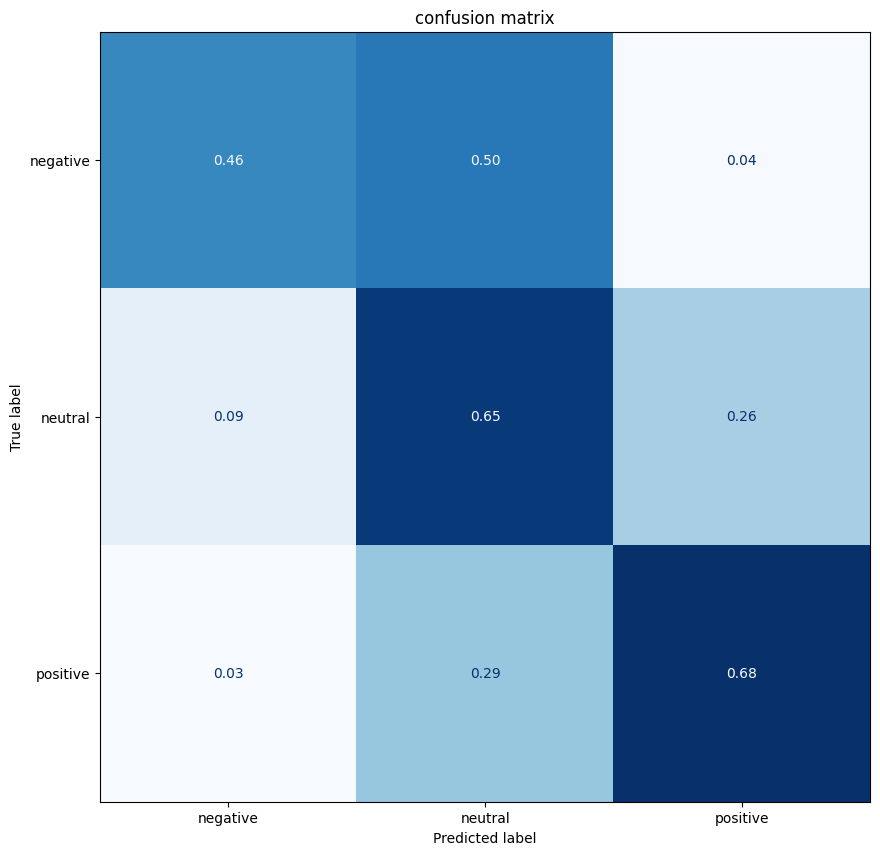

In [52]:
labels = train_dataset.features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)

## Validation

In [53]:
y_valid = np.array(validation_dataset["labels"])
preds_output = trainer.predict(validation_dataset)

In [54]:
preds_output.metrics

{'test_loss': 0.614773154258728,
 'test_accuracy': 0.7456681350954478,
 'test_f1': 0.7495149461379175,
 'test_precision': 0.7544564075470781,
 'test_recall': 0.7465344984837542,
 'test_runtime': 19.1268,
 'test_samples_per_second': 356.045,
 'test_steps_per_second': 9.934}

In [55]:
y_preds = np.argmax(preds_output.predictions, axis=1)

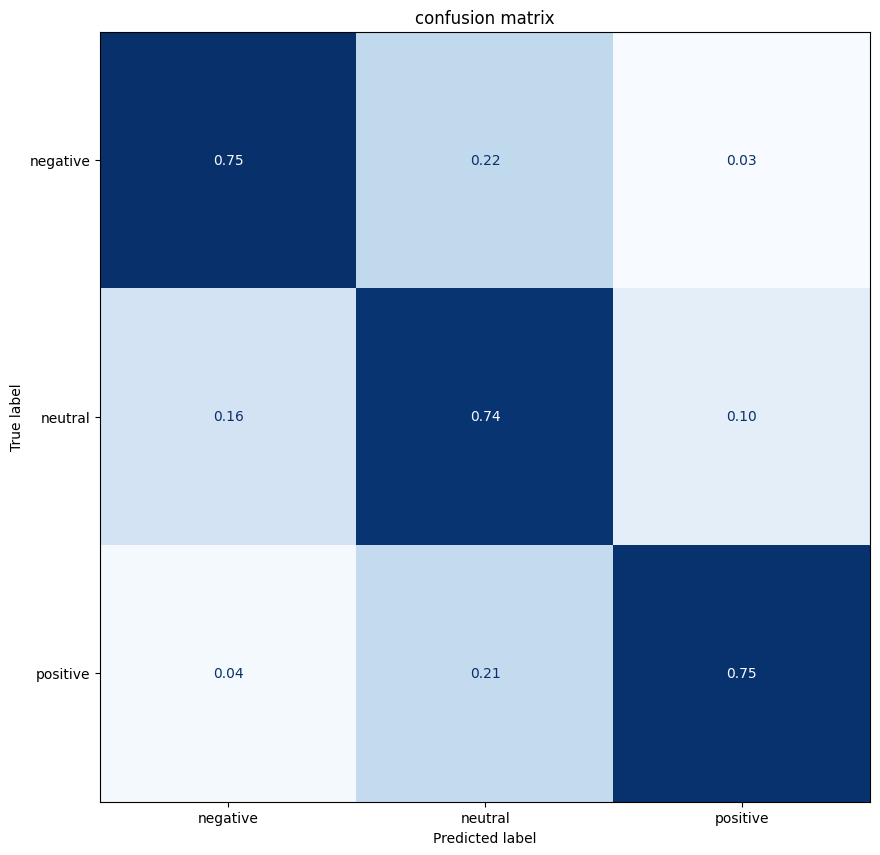

In [56]:
labels = train_dataset.features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)

In [57]:
%%notify
import time
time.sleep(1)

<IPython.core.display.Javascript object>